<a href="https://colab.research.google.com/github/BadGe-D/DATN/blob/main/ImageCaptioningTraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from time import time
from numpy import array

In [ ]:
import pandas as pd

# Try reading the file with a different encoding, such as 'latin1'
try:
    df = pd.read_csv("/content/drive/MyDrive/DATN/dataset/caption.csv", encoding='latin1')
except UnicodeDecodeError:
    # If 'latin1' doesn't work, try 'utf-16'
    try:
        df = pd.read_csv("/content/drive/MyDrive/DATN/dataset/caption.csv", encoding='utf-16')
    except UnicodeDecodeError:
        # If neither 'latin1' nor 'utf-16' work, try 'ISO-8859-1'
        df = pd.read_csv("/content/drive/MyDrive/DATN/dataset/caption.csv", encoding='ISO-8859-1')

df

,image,caption,caption(English)
0,1.jpg,"Phía bên ph?i có v?t c?n, ?i ch?ch v? bên trái...","There is an obstacle on the right, move slight..."
1,1.jpg,Có v?t c?n ? phía bên ph?i,There is an obstacle on the right side
2,1.jpg,"Bên ph?i có v?t c?n, ?i sang bên trái 1 tí","There is an obstacle on the right, move a litt..."
3,1.jpg,"Bên trái t??ng ??i v?ng, bên ph?i có v?t c?n","The left side is relatively clear, the right s..."
4,1.jpg,V?t c?n ? phía ph?i,Obstacle on the right side
...,...,...,...
576,122.jpg,NaN,"There are many consecutive obstacles ahead, bu..."
577,122.jpg,NaN,"Ahead, a series of manageable obstacles are li..."
578,122.jpg,NaN,There are multiple successive obstacles in fro...
579,122.jpg,NaN,Numerous obstacles are positioned consecutivel...


In [ ]:
train, val = np.split(df.sample( frac=1,random_state=42), [int(.8*len(df)),])
print(len(df), train.shape, val.shape)

581 (464, 3) (117, 3)


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [ ]:
image_path = '/content/drive/MyDrive/DATN/dataset/'

In [ ]:
import re
def caption_preprocessing(text, remove_digits=True):
  # remove punctuation
  pattern=r'[^a-zA-z0-9\s]'
  text=re.sub(pattern,'',text)

  # tokenize
  text=text.split()
  # convert to lower case
  text = [word.lower() for word in text]

  # remove tokens with numbers in them
  text = [word for word in text if word.isalpha()]
  # concat string
  text =  ' '.join(text)

  # insert 'startseq', 'endseq'
  text = 'startseq ' + text + ' endseq'
  return text


In [ ]:
df['caption(English)'] = df['caption(English)'].apply(caption_preprocessing)

In [ ]:
word_counts = {}  # a dict : { word : number of appearances}
max_length = 0
for text in df['caption(English)']:
  words = text.split()
  max_length = len(words) if (max_length < len(words)) else max_length
  for w in words:
    try:
      word_counts[w] +=1
    except:
        word_counts[w] = 1
print(len(word_counts))
print(max_length)

# Chỉ lấy các từ xuất hiện trên 1 lần
word_count_threshold = 1
vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('After preprocessed %d -> %d' % (len(word_counts), len(vocab)))

321
42
After preprocessed 321 -> 321


In [ ]:
i2w = {}
w2i = {}

id = 1
for w in vocab:
    w2i[w] = id
    i2w[id] = w
    id += 1

print(len(i2w), len(w2i))
print(i2w[300])

321 321
keeps


In [ ]:
! wget https://nlp.stanford.edu/data/glove.6B.zip

--2025-04-25 07:18:54--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-04-25 07:18:55--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

glove.6B.zip.1      100%[===================>] 822.24M  5.13MB/s    in 2m 39s  

2025-04-25 07:21:35 (5.16 MB/s) - ‘glove.6B.zip.1’ saved [862182613/862182613]

mkdir: cannot create directory ‘glove’: File exists
Archive:  glove.6B.zip
  End-of-central-directory sig

In [ ]:
! mkdir glove
! unzip glove.6B.zip -d glove

mkdir: cannot create directory ‘glove’: File exists
Archive:  glove.6B.zip
  inflating: glove/glove.6B.50d.txt  
  inflating: glove/glove.6B.100d.txt  
  inflating: glove/glove.6B.200d.txt  
  inflating: glove/glove.6B.300d.txt  


In [ ]:
glove_dir = '/content/glove/'
embeddings_index = {} # empty dictionary
file = open(glove_dir + 'glove.6B.200d.txt', encoding="utf-8")

for line in file:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
file.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
embeddings_index['left'].shape

(200,)

In [ ]:
embedding_dim = 200
vocab_size = len(vocab) + 1

In [ ]:
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in w2i.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector
print(embedding_matrix.shape)


(322, 200)


In [ ]:
from pickle import dump, load

In [ ]:
with open("/content/drive/MyDrive/DATN/Embedding_matrix.pkl", "wb") as file:
    dump(embedding_matrix, file)

In [ ]:
embedding_matrix = load(open("/content/drive/MyDrive/DATN/Embedding_matrix.pkl", "rb"))
embedding_matrix.shape

(322, 200)

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from keras.utils import plot_model # Import plot_model from tensorflow.keras.utils
# model needs to be defined before being used
model = InceptionV3()

# Tạo model mới, bỏ layer cuối từ inception v3
model_new = Model(model.input, model.layers[-2].output)
model_new.input_shape


96112376/96112376 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


(None, 299, 299, 3)

In [ ]:
images = {}
captions = {}

start = time()
for i in range(len(df)):
  images[df['image'][i]] = np.array(Image.open(image_path + df['image'][i])) # Make sure 'image_path' is correctly defined
  try:
    captions[df['image'][i]].append(df['caption(English)'][i])
  except:
    captions[df['image'][i]] = [df['caption(English)'][i]]

print(len(images), len(captions))
print('Time: ',time() - start)

116 116
Time:  24.088395357131958


In [ ]:
with open("/content/drive/MyDrive/DATN/encoded.pkl", "wb") as file:
    dump(captions, file)

In [ ]:
captions = load(open("/content/drive/MyDrive/DATN/encoded.pkl", "rb"))
len(captions)

116

In [ ]:
images[df['image'][0]].shape

(426, 640, 3)

In [ ]:
tmp = np.array([[0,2,1],[3,5,6]])
tmp = np.expand_dims(tmp, axis=0)
tmp

array([[[0, 2, 1],
        [3, 5, 6]]])

In [ ]:
from keras.applications.inception_v3 import preprocess_input
# Image embedding thành vector (2048, )
def encode(image):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = np.resize(image, (299, 299, 3 ))
    # Add one more dimension
    img = np.expand_dims(img, axis=0)
    # preprocess the images using preprocess_input() from inception module
    img = preprocess_input(img)

    fea_vec = model_new.predict(img) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec


In [ ]:
# Gọi hàm encode với các ảnh trong traning set
start = time()
encoding_image = {}
for id, img in images.items():
    encoding_image[id] = encode(img)
print("Time taken in seconds =", time()-start)

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━

In [ ]:
encoding_image['122.jpg'].shape

(2048,)

In [ ]:

from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_keys, test_keys = train_test_split(list(encoding_image.keys()), test_size=0.2, random_state=42)

# Create dictionaries for training and testing data
train_encoding_image = {key: encoding_image[key] for key in train_keys}
test_encoding_image = {key: encoding_image[key] for key in test_keys}

print("Training data size:", len(train_encoding_image))
print("Testing data size:", len(test_encoding_image))

# You can now use train_encoding_image and test_encoding_image for training and evaluation
# Example:
for key, value in train_encoding_image.items():
   print(f"Image {key}: {value.shape}")


Training data size: 92
Testing data size: 24
Image 16.jpg: (2048,)
Image 70.jpg: (2048,)
Image 32.jpg: (2048,)
Image 25.jpg: (2048,)
Image 57.jpg: (2048,)
Image 23.jpg: (2048,)
Image 64.jpg: (2048,)
Image 120.jpg: (2048,)
Image 83.jpg: (2048,)
Image 31.jpg: (2048,)
Image 87.jpg: (2048,)
Image 10.jpg: (2048,)
Image 34.jpg: (2048,)
Image 66.jpg: (2048,)
Image 68.jpg: (2048,)
Image 29.jpg: (2048,)
Image 46.jpg: (2048,)
Image 116.jpg: (2048,)
Image 6.jpg: (2048,)
Image 98.jpg: (2048,)
Image 67.jpg: (2048,)
Image 40.jpg: (2048,)
Image 36.jpg: (2048,)
Image 17.jpg: (2048,)
Image 74.jpg: (2048,)
Image 35.jpg: (2048,)
Image 75.jpg: (2048,)
Image 8.jpg: (2048,)
Image 44.jpg: (2048,)
Image 71.jpg: (2048,)
Image 78.jpg: (2048,)
Image 28.jpg: (2048,)
Image 20.jpg: (2048,)
Image 119.jpg: (2048,)
Image 100.jpg: (2048,)
Image 26.jpg: (2048,)
Image 9.jpg: (2048,)
Image 110.jpg: (2048,)
Image 51.jpg: (2048,)
Image 14.jpg: (2048,)
Image 84.jpg: (2048,)
Image 4.jpg: (2048,)
Image 18.jpg: (2048,)
Image 39

In [ ]:
train_features = train_encoding_image

In [ ]:
from pickle import dump, load
with open("/content/drive/MyDrive/DATN/encoded_train_images.pkl", "wb") as file:
    dump(train_encoding_image, file)

In [ ]:
train_features = load(open("/content/drive/MyDrive/DATN/encoded_train_images.pkl", "rb"))
len(train_features)

92

In [ ]:
test_features=test_encoding_image

In [ ]:
with open("/content/drive/MyDrive/DATN/encoded_test_images.pkl", "wb") as file:
    dump(test_encoding_image, file)

In [ ]:
test_feature = load(open("/content/drive/MyDrive/DATN/encoded_test_images.pkl", "rb"))
len(test_features)

24

In [ ]:
model="a"

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical


def data_generator(captions, images, w2i, max_length, batch_size):
  X_image, X_cap, y = [], [], []
  n = 0
  while 1:
    for id, caps in captions.items():
      n += 1
      image = images[id]
      for cap in caps:
        # encode the sequence
        seq = [w2i[word] for word in cap.split(' ') if word in w2i]

        for i in range(1, len(seq)):
          # split into input and output pair
          in_seq, out_seq = seq[:i], seq[i]

          # pad input sequence
          in_seq = pad_sequences([in_seq], maxlen=max_length,padding='post')[0]
          # encode output sequence
          out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

          # store
          X_image.append(image)
          X_cap.append(in_seq)
          y.append(out_seq)
      if n == batch_size:
        # Yielding as a tuple instead of a list
        yield (np.array(X_image), np.array(X_cap)), np.array(y)
        X_image, X_cap, y = [], [], []
        n = 0
  # # Define output_signature correctly using tf.TensorSpec
  # output_signature = (
  #     (tf.TensorSpec(shape=(batch_size, 2048), dtype=tf.float32),  # Image shape and type
  #      tf.TensorSpec(shape=(batch_size, max_length), dtype=tf.int32)),  # Caption shape and type
  #     tf.TensorSpec(shape=(batch_size, vocab_size), dtype=tf.float32)  # Output shape and type
  # )

  # # Create dataset from generator with output_signature
  # dataset = tf.data.Dataset.from_generator(
  #     lambda: data_generator(captions, images, w2i, max_length, batch_size),
  #     output_signature=output_signature
  # )

  # return dataset # Return the dataset


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import add
from tensorflow.keras.applications.inception_v3 import InceptionV3

from tensorflow.keras import Input
from tensorflow.keras import optimizers

In [ ]:
# Tạo model
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)

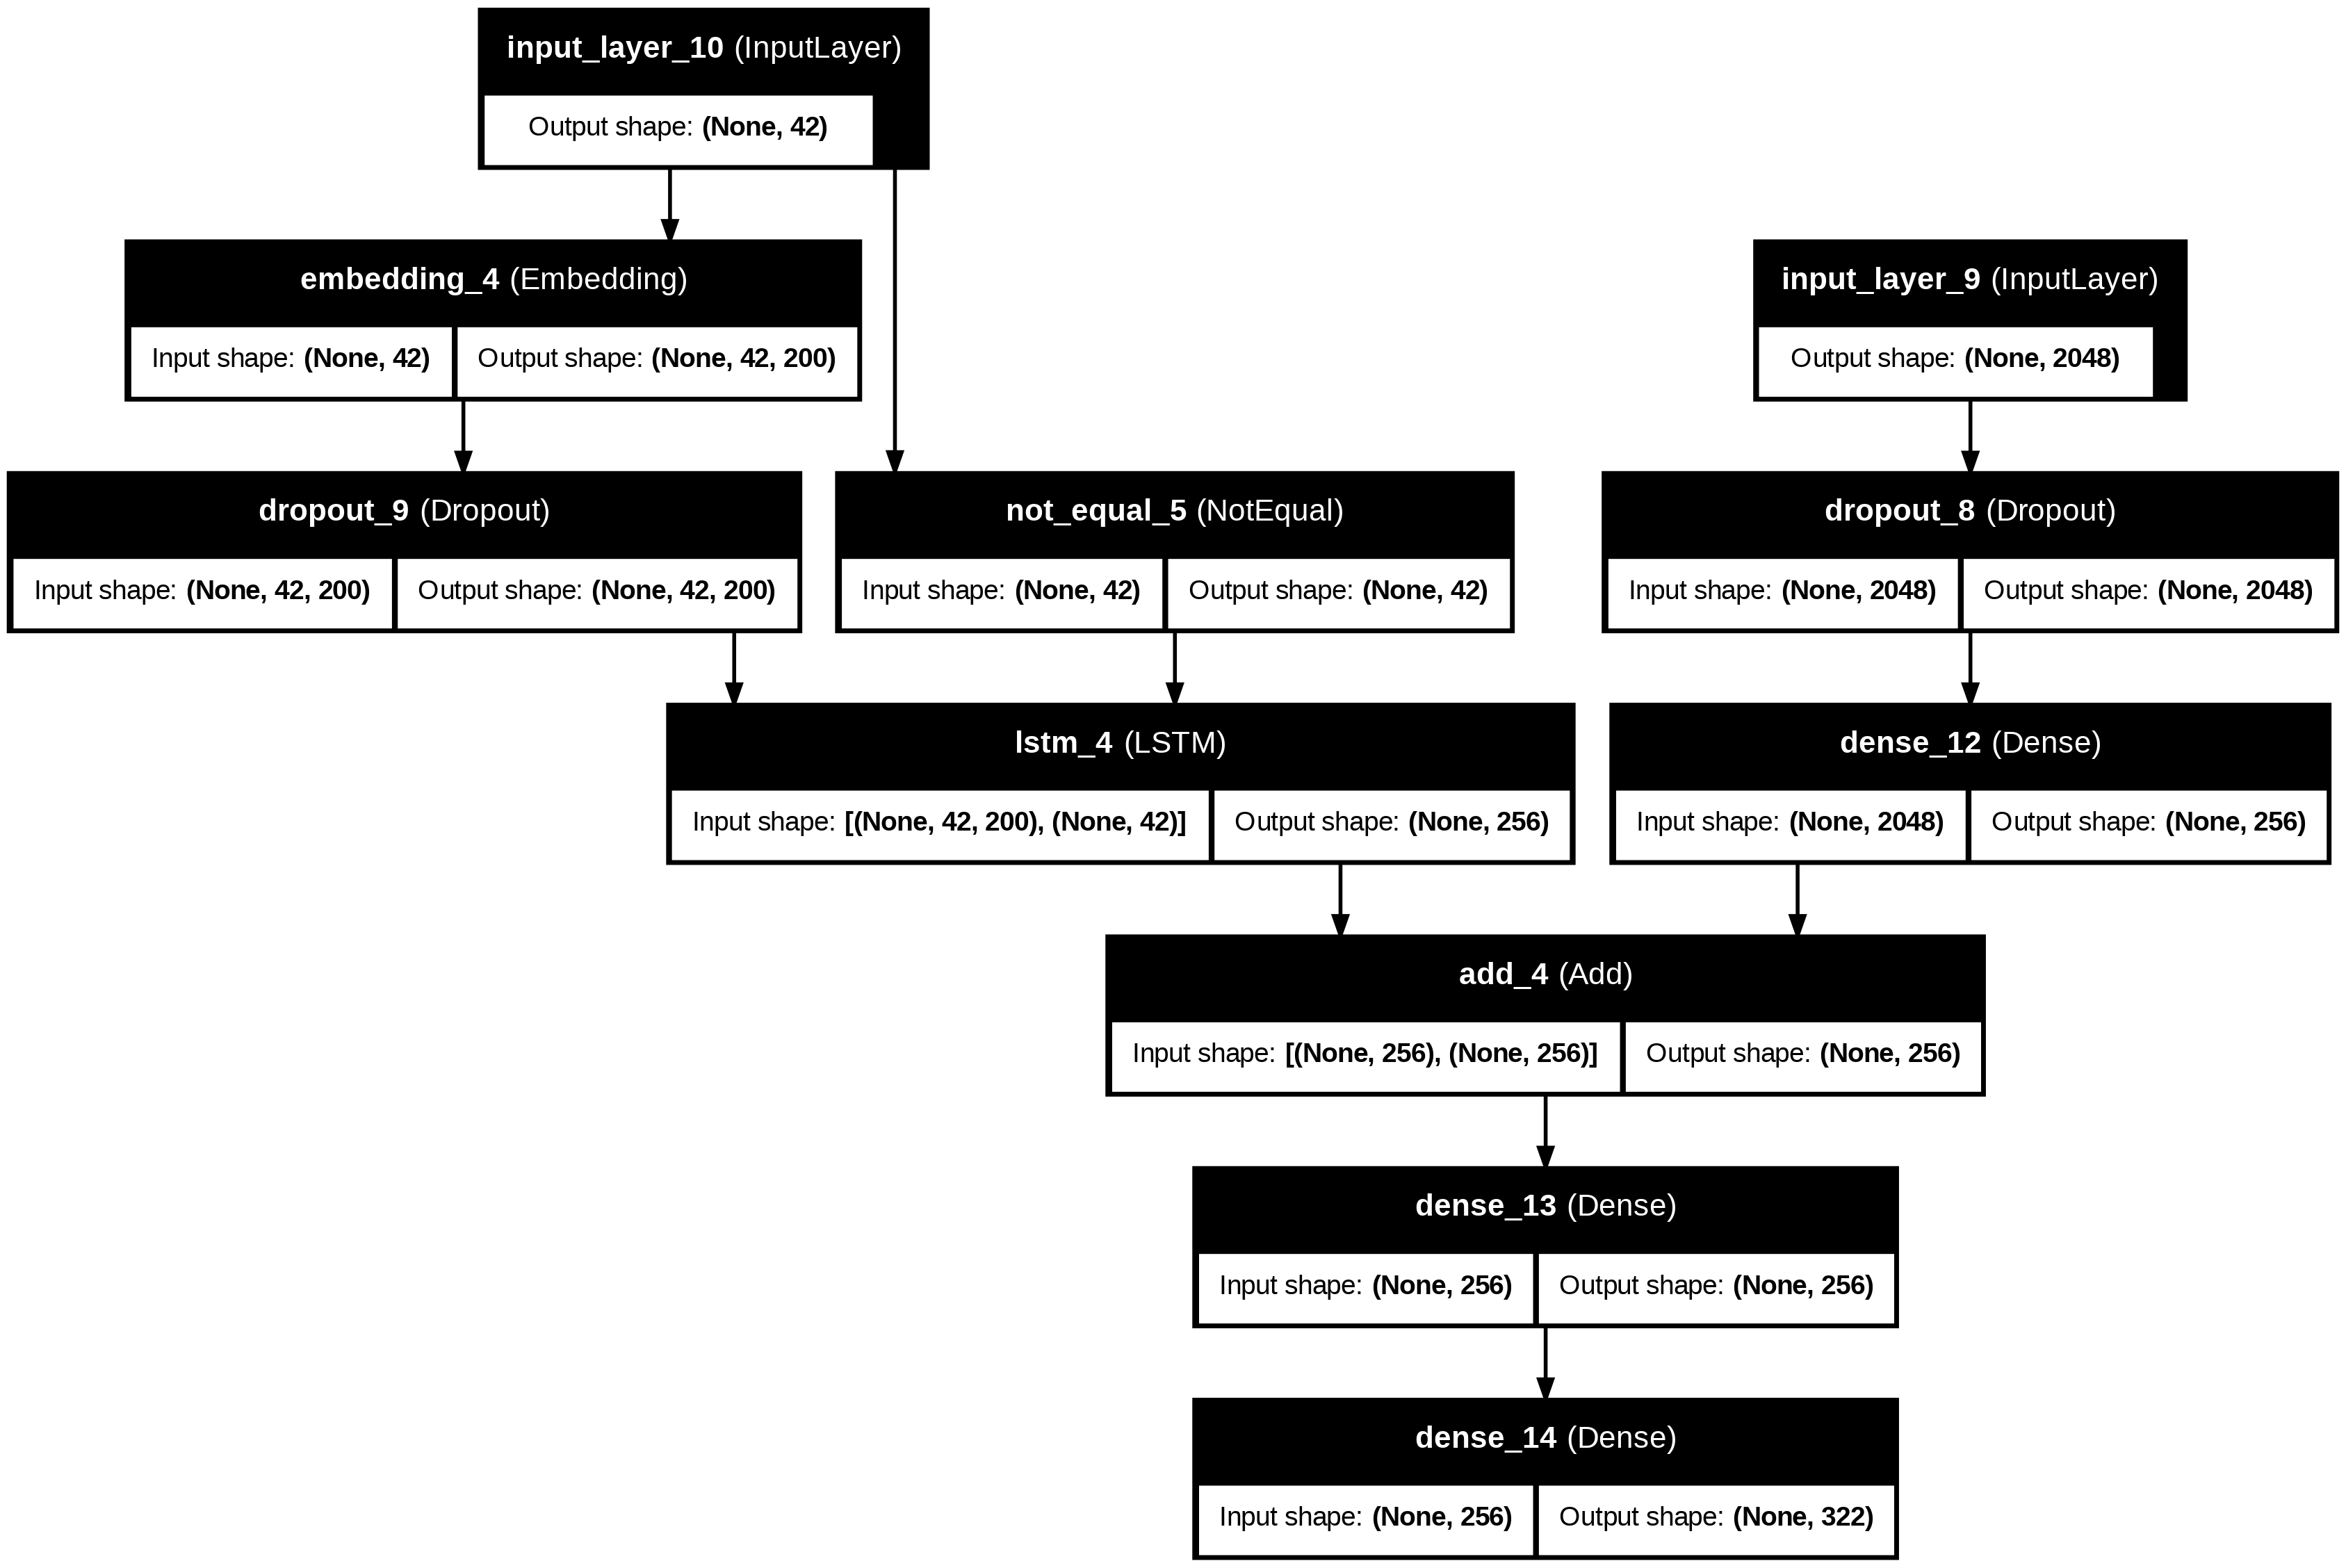

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 42)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_9       │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 42, 200)   │     64,400 │ input_layer_10[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 2048)      │          0 │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 42, 200)   │          0 │ embedding_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_5         │ (None, 42)        │          0 │ input_layer_10[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 256)       │    524,544 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 256)       │    467,968 │ dropout_9[0][0],  │
│                     │                   │            │ not_equal_5[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 256)       │          0 │ dense_12[0][0],   │
│                     │                   │            │ lstm_4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 256)       │     65,792 │ add_4[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 322)       │     82,754 │ dense_13[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,205,458 (4.60 MB)

 Trainable params: 1,205,458 (4.60 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.layers[2]

<Embedding name=embedding_4, built=True>

In [ ]:
# Layer 2 dùng GLOVE Model nên set weight thẳng và không cần train
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
model.optimizer.lr = 0.0001
epochs = 40
batch_size = 16
steps = len(train_features)

In [ ]:
checkpoint_path = "/content/drive/MyDrive/DATN/cp.weights.h5"  # Change the file extension to .weights.h5

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
cp_callback = ModelCheckpoint(filepath=checkpoint_path,save_best_only=False, save_weights_only=True, verbose=1)

In [ ]:
print(type(model))

<class 'keras.src.models.functional.Functional'>


In [ ]:
# # prompt: hãy tính điểm bleu score của mô hình trong quá trinh  huấn luyện

# import numpy as np
# from nltk.translate.bleu_score import corpus_bleu

# # Assuming you have your model predictions and true captions
# # predictions should be a list of lists of strings (predicted captions)
# # actual_captions should be a list of lists of strings (true captions)

# def calculate_bleu(model, captions, images, w2i, max_length):
#     actual, predicted = list(), list()
#     for key, desc_list in captions.items():
#         # yhat = generate_desc(model, images[key], w2i, max_length)
#         references = [d.split() for d in desc_list]
#         actual.append(references)
#         predicted.append(yhat.split())
#     print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
#     print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
#     print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
#     print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))


# # Example usage during training:
# # ... inside your training loop ...

# # After each epoch or at specific intervals, call the calculate_bleu function:

# calculate_bleu(model, captions, encoding_image, w2i, max_length) # Assuming 'encoding_image' holds the image features



In [ ]:
def greedySearch(model,photo):
    in_text = 'startseq'
    photo=photo.reshape(1,photo.shape[0])
    for i in range(max_length):
        sequence = [w2i[w] for w in in_text.split() if w in w2i]
        sequence = pad_sequences([sequence], maxlen=max_length,padding="post")
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = i2w[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [ ]:
# from tensorflow.keras.models import load_model
# from tensorflow.keras.utils import custom_object_scope
# # Đảm bảo rằng lớp NotEqual đã được định nghĩa và đăng ký trước đó
# model = tf.keras.models.load_model('/content/drive/MyDrive/DATN/model.keras')


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 11 variables whereas the saved optimizer has 20 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
import nltk
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
def calculate_model_bleu_corpus_level(model,captions,images):
    """
    Tính điểm BLEU corpus-level cho toàn bộ tập dữ liệu

    Args:
        references_list: Danh sách các reference captions cho mỗi ảnh
                        [[ref1_img1, ref2_img1, ...], [ref1_img2, ref2_img2, ...], ...]
        candidates_list: Danh sách các candidate captions từ mô hình cho mỗi ảnh
                        [candidate_img1, candidate_img2, ...]

    Returns:
        Điểm BLEU corpus-level
    """

    references_list, candidates_list= list(), list()
    for key, desc_list in captions.items():
        yhat = greedySearch(model=model,photo=images[key])
        references = [d.split() for d in desc_list]
        references_list.append(references)
        candidates_list.append(yhat.split())
    # Chuẩn bị dữ liệu cho corpus_bleu của NLTK
    # Mỗi reference cần ở dạng list of tokens
    formatted_references = []
    formatted_candidates = []

    for references, candidate in zip(references_list, candidates_list):
        # Tokenize references nếu chúng là chuỗi
        tokenized_refs = []
        for ref in references:
            if isinstance(ref, str):
                import nltk
                try:
                    nltk.data.find('tokenizers/punkt')
                except LookupError:
                    nltk.download('punkt')
                tokenized_refs.append(nltk.word_tokenize(ref.lower()))
            else:
                tokenized_refs.append(ref)

        # Tokenize candidate nếu là chuỗi
        if isinstance(candidate, str):
            tokenized_candidate = nltk.word_tokenize(candidate.lower())
        else:
            tokenized_candidate = candidate

        formatted_references.append(tokenized_refs)
        formatted_candidates.append(tokenized_candidate)

    # Tính corpus BLEU score
    smoothie = SmoothingFunction().method1
    corpus_score = corpus_bleu(
        formatted_references,
        formatted_candidates,
        weights=(0.25, 0.25, 0.25, 0.25),  # BLEU-4 standard
        smoothing_function=smoothie
    )

    return corpus_score

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 3.9769
Epoch 1: saving model to /content/drive/MyDrive/DATN/cp.weights.h5
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 3.9691
Loss: 3.2529757022857666
BLEU Score: 0.24850921954875277
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 1.9382
Epoch 1: saving model to /content/drive/MyDrive/DATN/cp.weights.h5
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - loss: 1.9359
Loss: 1.7257500886917114
BLEU Score: 0.19829675275976807
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 1.1947
Epoch 1: saving model to /content/drive/MyDrive/DATN/cp.weights.h5
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 97ms/step - loss: 1.1933
Loss: 1.0639207363128662
BLEU Score: 0.2083553092253844
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.7920
Epoch 1: saving model to /content/drive/MyDrive/DATN/cp.weights.h5
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - loss: 0.7914
Loss: 0.7287465333938599
BLEU Score: 0.2063482946903126
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.5439
Epoch 1:

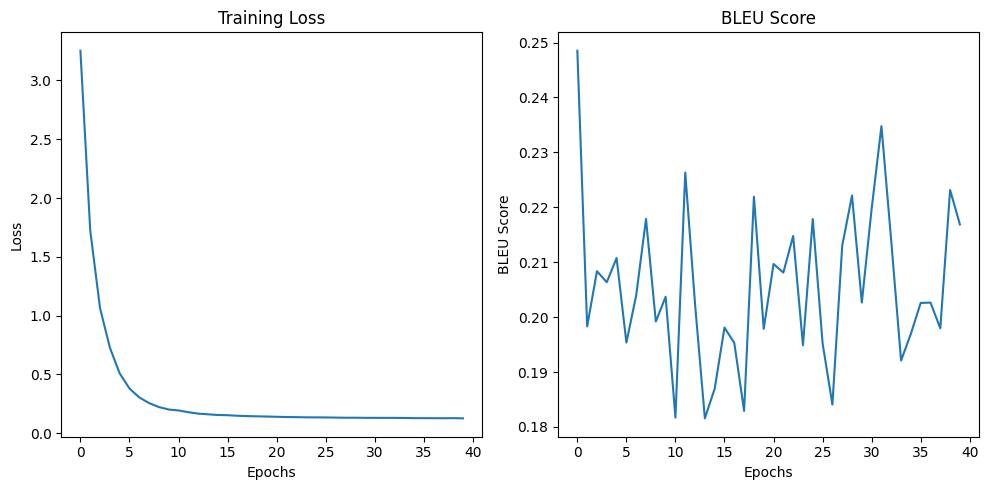

In [ ]:
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import custom_object_scope


# Define lists to store history
history_loss = []
history_bleu = []
# Filter captions to only include images that are in train_features
filtered_captions = {id: caps for id, caps in captions.items() if id in train_features}
filtered_captions_test = {id: caps for id, caps in captions.items() if id in test_features}
# Training loop
for i in range(epochs):
    generator = data_generator(
        captions=filtered_captions,  # Use filtered captions here
        images=train_features,
        w2i=w2i,
        max_length=max_length,
        batch_size=batch_size
    )

    history = model.fit(
        generator,
        epochs=1,
        steps_per_epoch=steps,
        callbacks=[cp_callback], # Added the callback for model checkpoints
        verbose=1
    )

    # Append loss to history
    loss = history.history['loss'][0]  # Get loss from history
    history_loss.append(loss)
    print("Loss:", loss)

    # Đảm bảo rằng lớp NotEqual đã được định nghĩa và đăng ký trước đó
    # model_test = tf.keras.models.load_model('/content/drive/MyDrive/DATN/model2.keras')
    # Calculate BLEU score
    bleu_score = calculate_model_bleu_corpus_level(model=model,captions=filtered_captions_test,images=test_features)
    history_bleu.append(bleu_score)
    print("BLEU Score:", bleu_score)

# Plot the loss and BLEU score
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')

plt.subplot(1, 2, 2)
plt.plot(history_bleu)
plt.xlabel('Epochs')
plt.ylabel('BLEU Score')
plt.title('BLEU Score')

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()


In [ ]:
model.save_weights('/content/drive/MyDrive/DATN/model2.weights.h5')

In [ ]:
model.save('/content/drive/MyDrive/DATN/model2.keras')

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import custom_object_scope
# Đảm bảo rằng lớp NotEqual đã được định nghĩa và đăng ký trước đó
model = tf.keras.models.load_model('/content/drive/MyDrive/DATN/model2.keras')

In [ ]:
model_new.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 299, 299, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_188 (Conv2D)       │ (None, 149, 149, 32)   │            864 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_188   │ (None, 149, 149, 32)   │             96 │ conv2d_188[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_188            │ (None, 149, 149, 32)   │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_189 (Conv2D)       │ (None, 147, 147, 32)   │          9,216 │ activation_188[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_189   │ (None, 147, 147, 32)   │             96 │ conv2d_189[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_189            │ (None, 147, 147, 32)   │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_190 (Conv2D)       │ (None, 147, 147, 64)   │         18,432 │ activation_189[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_190   │ (None, 147, 147, 64)   │            192 │ conv2d_190[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_190            │ (None, 147, 147, 64)   │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_8           │ (None, 73, 73, 64)     │              0 │ activation_190[0][0]   │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_191 (Conv2D)       │ (None, 73, 73, 80)     │          5,120 │ max_pooling2d_8[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_191   │ (None, 73, 73, 80)     │            240 │ conv2d_191[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_191            │ (None, 73, 73, 80)     │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_192 (Conv2D)  

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 21,768,352 (83.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

251    startseq on the right there is an obstacle the...
252    startseq must be blocked in front of the small...
253    startseq obstacle on the right narrow path ahe...
254    startseq on the right there is an obstacle in ...
255    startseq must be blocked in front the road nar...
Name: caption(English), dtype: object


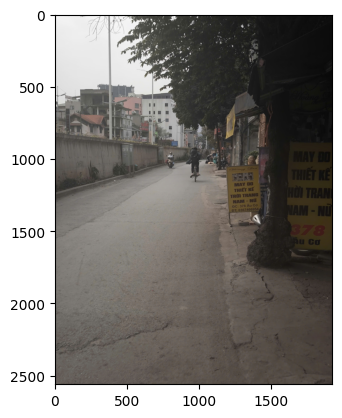

must be blocked in front the road narrows on the left there is a moving vehicle


In [ ]:
pic = list(train_features.keys())[50]
image = train_features[pic].reshape((1,2048))
img = Image.open(image_path + pic)
print(df['caption(English)'][df['image'] == pic])
plt.imshow(img)
plt.show()
predict = greedySearch(image)
print(predict)

In [ ]:
pic

'52.jpg'

In [ ]:
# @title TESTING
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
model = tf.keras.models.load_model('/content/drive/MyDrive/DATN/model.keras')

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 11 variables whereas the saved optimizer has 20 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
def TestingGreedySearch(photo):
    in_text = 'startseq'
    for i in range(42):
        sequence = [w2i[w] for w in in_text.split() if w in w2i]
        sequence = pad_sequences([sequence], maxlen=42,padding="post")
        # Use the trained model (`model`) for prediction instead of `model_new`
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = i2w[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

Saving test.jpg to test (7).jpg
User uploaded file "test (7).jpg" with length 2171999 bytes


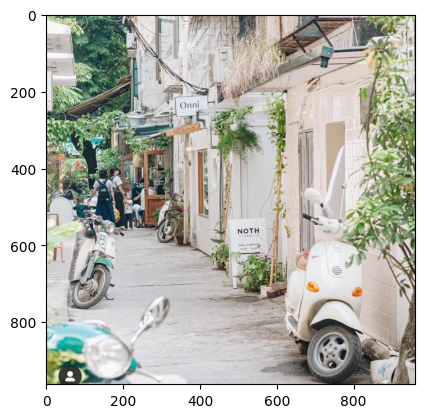

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
the road ahead is crowded with obstacles on both sides


In [ ]:
import numpy as np
from google.colab import files
import matplotlib.pyplot as plt
from PIL import Image

uploaded = files.upload()
predict=""
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

  # Assuming the uploaded file is the image
  image_path = fn  # Use the uploaded filename

  try:
      img = Image.open(image_path)
      plt.imshow(img)
      plt.show()
      # Assuming 'encode' and 'greedySearch' functions are defined as in your previous code
      image = encode(np.array(img))  # Encode the image
      image = image.reshape((1, 2048))
      predict = TestingGreedySearch(image)
      print(predict)

  except Exception as e:
      print(f"Error processing image: {e}")


In [ ]:
!pip install gtts
!pip install googletrans

In [ ]:
from gtts import gTTS
from IPython.display import Audio
import googletrans
import asyncio
import nest_asyncio

# Apply nest_asyncio to allow nested event loops
nest_asyncio.apply()

async def translate_text(text, target_language='vi'):
    translator = googletrans.Translator()
    # Use await to get the result of the coroutine
    translated = await translator.translate(text, dest=target_language)
    return translated.text

def text_to_speech_translation(text, target_language='vi', filename="speech.mp3"):
    # Get the event loop using nest_asyncio
    loop = asyncio.get_event_loop()
    # Run the translate_text coroutine in the event loop
    translated_text = loop.run_until_complete(translate_text(text, target_language))
    # Create and save the audio file
    tts = gTTS(text=translated_text, lang=target_language)
    tts.save(filename)
    return filename

# Example usage with the 'predict' variable:
print(predict)
audio_file = text_to_speech_translation(predict)
Audio(audio_file, autoplay=True)

<function translate_text at 0x7a18083a8ea0>
